In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

n is the number of observations (or data points), while p is the number of predictors.

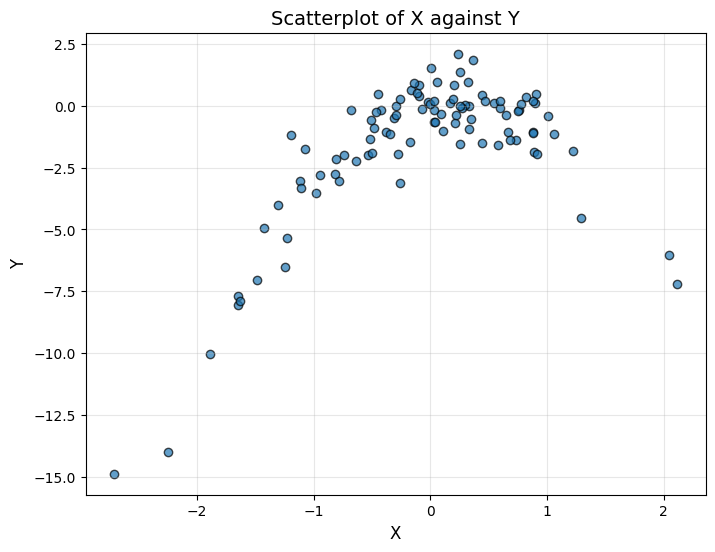

In [3]:
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.7, edgecolors='k')
plt.title("Scatterplot of X against Y", fontsize=14)
plt.xlabel("X", fontsize=12)
plt.ylabel("Y", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

Y is decreasing while X is increasing in magnitude, forming a shape that looks very similar to a parabola. Adding the "+ rng.normal(size=100)" to the end of the equation takes away the perfect parabola shape, however, giving the parabola a little variation.

LOOCV Errors
The Leave-One-Out Cross-Validation (LOOCV) errors for polynomial models of degrees 1 to 4 are:

Degree 1: 6.6330
Degree 2: 1.1229
Degree 3: 1.3018
Degree 4: 1.3324

The degree 2 model achieves the lowest LOOCV error, indicating that it is the best fit for the data.
Degrees 3 and 4 overfit slightly, as evidenced by higher LOOCV errors compared to degree 2.

The LOOCV findings are better statistically. The degree 2 model is the best choice; it captures the relationship well without overfitting. The higher degree models included unnecessary terms.

In [4]:
boston = pd.read_csv("Boston.csv")

In [5]:
boston.head()

,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [8]:
estimate_mu_hat = boston['medv'].mean()
estimate_mu_hat

np.float64(22.532806324110677)

In [10]:
std_dev = boston['medv'].std()
n = len(boston['medv'])
standard_error = std_dev / (n ** 0.5)
standard_error

np.float64(0.40886114749753505)

This insinuates that the line is pretty accurate; the standard error is less then 0.5. Most points on the graph will come pretty close to the prediction line

In [11]:
num_bootstrap_samples = 1000
bootstrap_means = []
for _ in range(num_bootstrap_samples):
    bootstrap_sample = boston['medv'].sample(frac=1, replace=True)
    bootstrap_means.append(bootstrap_sample.mean())

bootstrap_se = np.std(bootstrap_means)
bootstrap_se

np.float64(0.40301479646717164)

The bootstrap standard error is very, very close to the same number. The difference was about 0.005, showing super similar results.

In [13]:
ci_lower_bootstrap = np.percentile(bootstrap_means, 2.5)
ci_upper_bootstrap = np.percentile(bootstrap_means, 97.5)

print(f"95% Confidence Interval using Bootstrap: ({ci_lower_bootstrap}, {ci_upper_bootstrap})")

95% Confidence Interval using Bootstrap: (21.70653656126482, 23.315844861660082)


In [12]:
sample_mean = boston['medv'].mean()
std_dev = boston['medv'].std()
n = len(boston['medv'])
standard_error = std_dev / (n ** 0.5)
z = 1.96  # Critical value for 95% CI
ci_lower = sample_mean - z * standard_error
ci_upper = sample_mean + z * standard_error

print(f"95% Confidence Interval using Standard Error: ({ci_lower}, {ci_upper})")

95% Confidence Interval using Standard Error: (21.73143847501551, 23.334174173205845)


Once again, the numbers provided by the bootstrap technique and the normal standard error technique are very similar, almost the exact same. This continues to show how these different methods are one in the same.

In [14]:
median_medv = boston['medv'].median()
median_medv

np.float64(21.2)

In [16]:
bootstrap_medians = []
num_bootstrap_samples = 1000
for _ in range(num_bootstrap_samples):
    bootstrap_sample = boston['medv'].sample(frac=1, replace=True)
    bootstrap_medians.append(bootstrap_sample.median())

ci_lower = np.percentile(bootstrap_medians, 2.5)
ci_upper = np.percentile(bootstrap_medians, 97.5)

print(f"Bootstrap Estimate of Median: {np.median(bootstrap_medians)}")
print(f"95% Confidence Interval for Median: ({ci_lower}, {ci_upper})")

Bootstrap Estimate of Median: 21.2
95% Confidence Interval for Median: (20.5, 21.9)


The confidence interval of the median is significantly smaller than that of the mean. It begins and ends with numbers smaller, ranging from 20.5 (mean was 21.7) to 21.9 (mean was 23.3).

In [17]:
rng = np.random.default_rng(seed=42)
n = 100
X = rng.normal(loc=0, scale=1, size=n)
noise = rng.normal(loc=0, scale=1, size=n)
print("Predictor X:", X[:5])
print("Noise vector:", noise[:5])

Predictor X: [ 0.30471708 -1.03998411  0.7504512   0.94056472 -1.95103519]
Noise vector: [-0.37816255  1.2992283  -0.35626397  0.73751557 -0.93361768]


In [18]:
beta_0 = 2
beta_1 = 3
beta_2 = -1
beta_3 = 0.5
Y = beta_0 + beta_1 * X + beta_2 * X**2 + beta_3 * X**3 + noise
print("Response vector Y:", Y[:5])

Response vector Y: [  2.45728306  -1.46469718   3.54323104   5.09058866 -12.30660665]


In [20]:
pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 48.0 MB/s eta 0:00:00:00:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [21]:
import statsmodels.api as sm

In [22]:
X_poly = np.column_stack([X**i for i in range(1, 11)])
n = len(X)
X_with_intercept = sm.add_constant(X_poly)  # Add intercept to the predictors
def calculate_cp(model, X, y):
    n = len(y)
    p = len(model.params)
    y_pred = model.predict(X)
    residuals = y - y_pred
    sse = np.sum(residuals**2)
    mse = sse / (n - p)
    cp = (sse / mse) - (n - 2 * p)
    return cp
y = Y
remaining_predictors = list(range(1, 11))  # Predictors X, X^2, ..., X^10
selected_predictors = []
cp_values = []
while remaining_predictors:
    cp_min = np.inf
    best_predictor = None
    for predictor in remaining_predictors:
        predictors_subset = selected_predictors + [predictor]
        X_subset = X_with_intercept[:, [0] + predictors_subset]  # Include intercept
        model = sm.OLS(y, X_subset).fit()  # Fit model
        cp = calculate_cp(model, X_subset, y)
        
        if cp < cp_min:
            cp_min = cp
            best_predictor = predictor
    
    selected_predictors.append(best_predictor)
    remaining_predictors.remove(best_predictor)
    cp_values.append(cp_min)

final_X = X_with_intercept[:, [0] + selected_predictors]  # Include intercept
final_model = sm.OLS(y, final_X).fit()

print("Final model summary:")
print(final_model.summary())
print("\nSelected predictors:", selected_predictors)
print("\nModel coefficients:", final_model.params)


Final model summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     120.2
Date:                Sun, 24 Nov 2024   Prob (F-statistic):           3.15e-47
Time:                        02:40:19   Log-Likelihood:                -134.01
No. Observations:                 100   AIC:                             290.0
Df Residuals:                      89   BIC:                             318.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9847      0.23

In [23]:
def backward_stepwise_selection(X_with_intercept, y):
    remaining_predictors = list(range(1, 11))  # X, X^2, ..., X^10
    selected_predictors = list(range(1, 11))  # Start with all predictors
    cp_values = []
    
    while len(selected_predictors) > 1:  # Keep going until only the intercept is left
        cp_min = np.inf
        worst_predictor = None
        
        for predictor in selected_predictors:
            predictors_subset = [p for p in selected_predictors if p != predictor]
            X_subset = X_with_intercept[:, [0] + predictors_subset]  # Include intercept
            model = sm.OLS(y, X_subset).fit()
            cp = calculate_cp(model, X_subset, y)
            
            if cp < cp_min:
                cp_min = cp
                worst_predictor = predictor
        
        selected_predictors.remove(worst_predictor)
        cp_values.append(cp_min)

    final_X = X_with_intercept[:, [0] + selected_predictors]  # Include intercept
    final_model = sm.OLS(y, final_X).fit()

    return final_model, selected_predictors

final_model_backwards, selected_predictors_backwards = backward_stepwise_selection(X_with_intercept, y)

print("Final model summary (Backward Stepwise Selection):")
print(final_model_backwards.summary())
print("\nSelected predictors:", selected_predictors_backwards)
print("\nModel coefficients:", final_model_backwards.params)

Final model summary (Backward Stepwise Selection):
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                  0.007283
Date:                Sun, 24 Nov 2024   Prob (F-statistic):              0.932
Time:                        02:43:35   Log-Likelihood:                -267.74
No. Observations:                 100   AIC:                             539.5
Df Residuals:                      98   BIC:                             544.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c

The coefficients for the backwards stepwise function are much smaller than the stepwise.

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09064683890342451, tolerance: 0.0735060932176365
  model = cd_fast.enet_coordinate_descent_gram(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2620718030856821, tolerance: 0.0735060932176365
  model = cd_fast.enet_coordinate_descent_gram(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.30003097613405316, tolerance: 0.0735060932176365
  model = cd_fast.enet_coordinate_descent_gram(
/home/codespace/.local/lib/python3.12/site-packages/sklearn

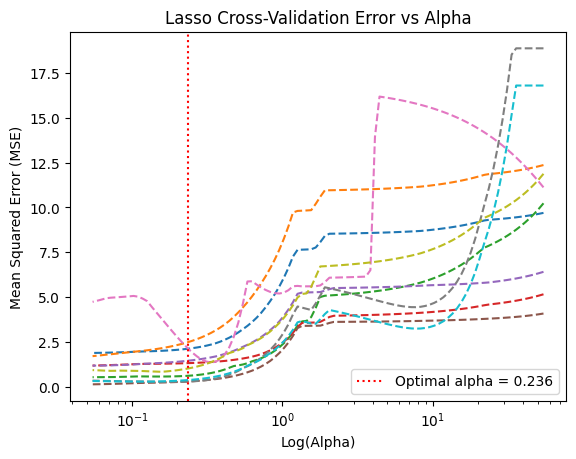

Optimal Alpha (Lambda): 0.23626649018731094
Lasso Model Coefficients: [ 2.46362096 -0.          0.         -0.          0.         -0.39068547
  0.18618515 -0.          0.          0.04845369]
Test R^2 Score: -23.56307733691489


In [26]:
X_poly = np.column_stack([X**i for i in range(1, 11)])
y = Y
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)
lasso_cv = LassoCV(cv=10, random_state=42)
lasso_cv.fit(X_train, y_train)
optimal_alpha = lasso_cv.alpha_

plt.plot(lasso_cv.alphas_, lasso_cv.mse_path_, linestyle='--')
plt.axvline(optimal_alpha, linestyle=':', color='red', label=f'Optimal alpha = {optimal_alpha:.3f}')
plt.xscale('log')
plt.xlabel('Log(Alpha)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Lasso Cross-Validation Error vs Alpha')
plt.legend()
plt.show()

lasso_model = lasso_cv
print(f"Optimal Alpha (Lambda): {optimal_alpha}")
print("Lasso Model Coefficients:", lasso_model.coef_)

test_score = lasso_model.score(X_test, y_test)
print(f"Test R^2 Score: {test_score}")


The lasso method performs regularization, which causes some coefficients to be exactly zero. This is helpful in selecting important predictors and removing irrelevant ones. 

In [27]:
from itertools import combinations

In [28]:
X = boston.drop(columns=['crim'])
y = boston['crim']
X_with_intercept = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X_with_intercept, y, test_size=0.2, random_state=42)
def compute_aic(model):
    return model.aic
best_aic = np.inf
best_subset = None
best_model = None

for k in range(1, X_train.shape[1]):  # Start with 1 predictor to all predictors
    for subset in combinations(X_train.columns, k):
        X_subset = X_train[list(subset)]
        model = sm.OLS(y_train, sm.add_constant(X_subset)).fit()
        aic = compute_aic(model)
        
        if aic < best_aic:
            best_aic = aic
            best_subset = subset
            best_model = model

print("Best Subset of Predictors:", best_subset)
print("\nBest Model Summary (with lowest AIC):")
print(best_model.summary())
X_test_subset = X_test[list(best_subset)]
test_model = sm.OLS(y_test, sm.add_constant(X_test_subset)).fit()

print("\nTest Model Summary:")
print(test_model.summary())

Best Subset of Predictors: ('zn', 'nox', 'dis', 'rad', 'ptratio', 'medv')

Best Model Summary (with lowest AIC):
                            OLS Regression Results                            
Dep. Variable:                   crim   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     49.00
Date:                Sun, 24 Nov 2024   Prob (F-statistic):           6.10e-45
Time:                        02:59:37   Log-Likelihood:                -1342.8
No. Observations:                 404   AIC:                             2700.
Df Residuals:                     397   BIC:                             2728.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

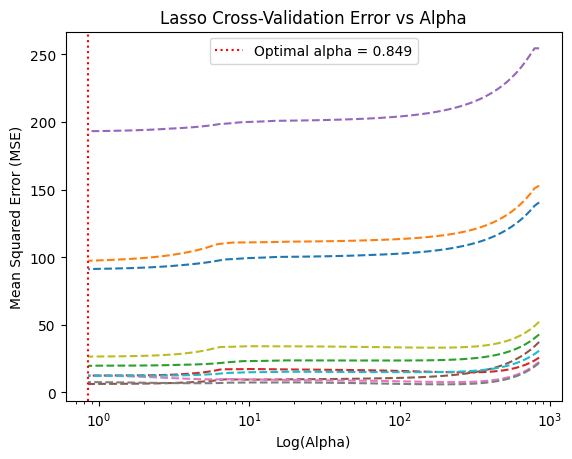

Optimal Alpha (Lambda): 0.8486933195540266
Lasso Model Coefficients: [ 3.48970723e-04  2.45741850e-02 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  2.25179149e-02 -6.20837732e-02
  5.30756906e-01  1.83129892e-04 -0.00000000e+00  2.83404857e-02
 -1.36436505e-01]
Test R^2 Score: 0.513480463437485


In [29]:
X = boston.drop(columns=['crim'])
y = boston['crim']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lasso_cv = LassoCV(cv=10, random_state=42)  # 10-fold cross-validation
lasso_cv.fit(X_train, y_train)
optimal_alpha = lasso_cv.alpha_

plt.plot(lasso_cv.alphas_, lasso_cv.mse_path_, linestyle='--')
plt.axvline(optimal_alpha, linestyle=':', color='red', label=f'Optimal alpha = {optimal_alpha:.3f}')
plt.xscale('log')
plt.xlabel('Log(Alpha)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Lasso Cross-Validation Error vs Alpha')
plt.legend()
plt.show()

lasso_model = lasso_cv
print(f"Optimal Alpha (Lambda): {optimal_alpha}")
print("Lasso Model Coefficients:", lasso_model.coef_)
test_score = lasso_model.score(X_test, y_test)
print(f"Test R^2 Score: {test_score}")

In [30]:
from sklearn.linear_model import RidgeCV

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:102: FutureWarning: Attribute `cv_values_` is deprecated in version 1.5 and will be removed in 1.7. Use `cv_results_` instead.
  warnings.warn(msg, category=FutureWarning)


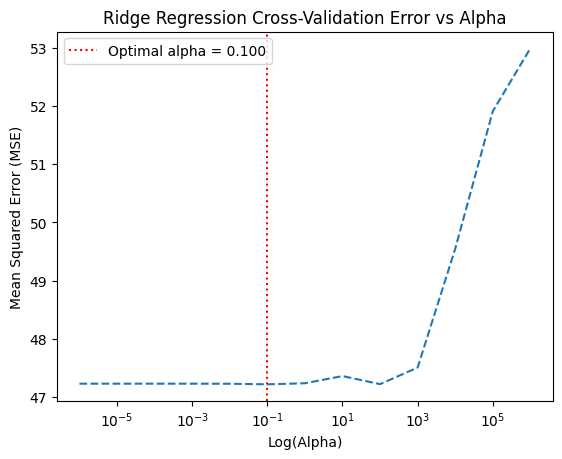

Optimal Alpha (Lambda): 0.1
Ridge Regression Model Coefficients: [-1.31153801e-03  4.49119753e-02 -2.47382219e-02 -1.05266370e+00
 -1.07881442e+01  7.12465319e-01  7.14315010e-03 -1.02805699e+00
  6.48331301e-01 -3.44946288e-03 -3.18773354e-01  3.26195843e-02
 -2.51942214e-01]
Test R^2 Score: 0.5399126942166845


In [31]:
X = boston.drop(columns=['crim'])
y = boston['crim']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
alphas = np.logspace(-6, 6, 13)  # Range of alpha values for cross-validation
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train, y_train)
optimal_alpha = ridge_cv.alpha_

plt.plot(alphas, ridge_cv.cv_values_.mean(axis=0), linestyle='--')
plt.axvline(optimal_alpha, linestyle=':', color='red', label=f'Optimal alpha = {optimal_alpha:.3f}')
plt.xscale('log')
plt.xlabel('Log(Alpha)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Ridge Regression Cross-Validation Error vs Alpha')
plt.legend()
plt.show()

ridge_model = ridge_cv
print(f"Optimal Alpha (Lambda): {optimal_alpha}")
print("Ridge Regression Model Coefficients:", ridge_model.coef_)
test_score = ridge_model.score(X_test, y_test)
print(f"Test R^2 Score: {test_score}")

While all the models are pretty similar, and use very similar coding, the lasso method is my favorite. I specifically like the graph that is easily generated with the lasso method that shows the optimal alpha. I also was the most familiar with the lasso method so that made it easier to understand. 

No, the lasso model does not involve all the features of the data set; it finds predictors that don't heavily affect the model and makes those coefficients zero. I like this feature of the lasso method a lot!